In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import re
import pynlpir
pynlpir.open()
from sklearn import metrics

from generate import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

### Load model

In [13]:
model = torch.load('models/linux_2_3x512_0d2_gru_50l_20000_E2000').cuda()
# model = torch.load('models/all.txt.model').cuda()

### Helper functions

In [14]:
def wrap_colored_output(text, colors, W=20):
    ''' Wrap text with hidden units to certain width '''
    new_text, new_colors = [], []
    for char, color in zip(text, colors):
        new_text.append(char)
        new_colors.append(color)
        if char == '\n':
            for i in range(W - len(new_text) % W):
                new_text.append(' ')
                new_colors.append(np.zeros_like(colors[0]))
    for i in range(W - len(new_text) % W):
        new_text.append(' ')
        new_colors.append(np.zeros_like(colors[0]))
    
    return np.array(new_text).reshape(-1, W), np.array(new_colors).reshape(-1, W)

In [15]:
def plot_colored_text(text, colors, W=60, title=None, save_file=None):
    wrapped_text, wrapped_colors = wrap_colored_output(text, colors, W=W)
    
    H = len(wrapped_text)
    plt.figure(figsize=(W/5, H/3))
    sns.heatmap(wrapped_colors, annot=wrapped_text, fmt='s',
                cbar=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    if save_file:
        plt.savefig(save_file)
    plt.show()

In [16]:
text, hiddens = generate(model, '\n\n', 500, 0.8, True, output_hiddens=True)
print(len(text))
print(len(hiddens))

500
500


### Define hypotheses

In [17]:
def hypothesis_inlinecounter(text):
    hyp = np.concatenate([np.linspace(1, -1, len(x)+1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_capswords(text):
    hyp = np.concatenate([np.full(len(x)+1, 1) if re.sub('[^a-zA-Z]+', '', x).isupper() else np.full(len(x)+1, -1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_pos(text, pos_tag):
    hyp = text.replace('1', '0')
    for word, tag in pynlpir.segment(text):
        if tag == pos_tag:
            hyp = hyp.replace(word, '1'*len(word), 1)
        else:
            hyp = hyp.replace(word, '0'*len(word), 1)
    hyp = [1 if x=='1' else -1 for x in re.sub('[^1]', '0', hyp)]
    
    return hyp

def hypothesis_verbs(text):
    return hypothesis_pos(text, 'verb')

def hypothesis_nouns(text):
    return hypothesis_pos(text, 'noun')

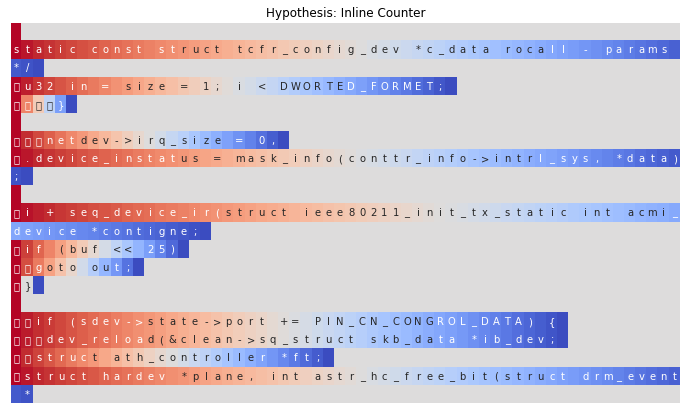

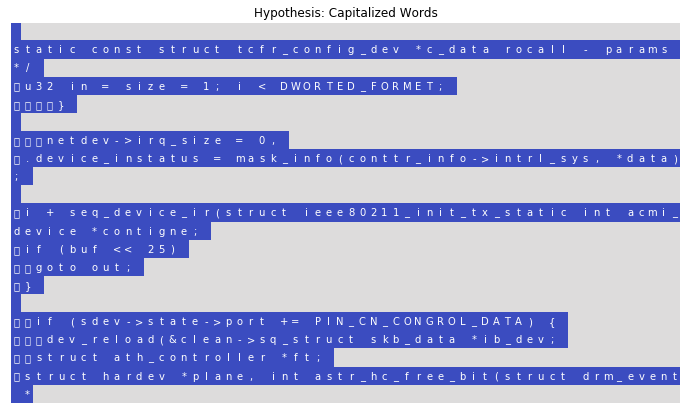

part of speech not recognized: 'gjtgj'


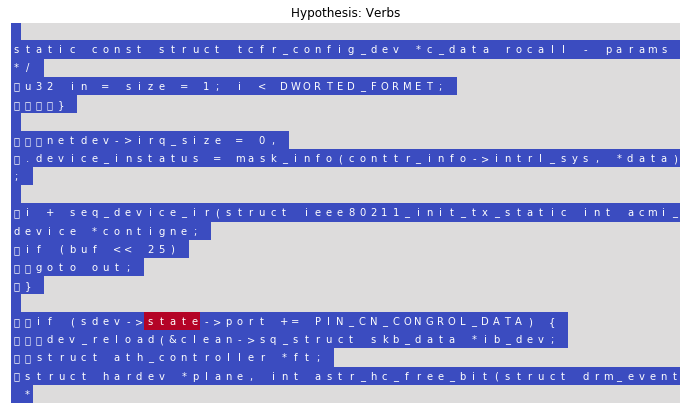

part of speech not recognized: 'gjtgj'


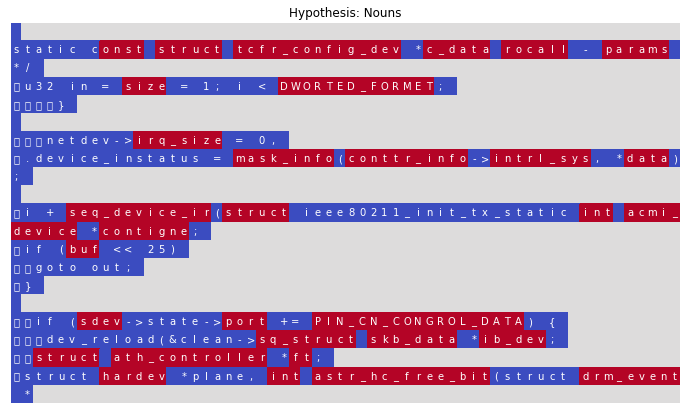

In [18]:
plot_colored_text(text, hypothesis_inlinecounter(text), title='Hypothesis: Inline Counter', save_file='hyp_inlinecounter.png')
plot_colored_text(text, hypothesis_capswords(text), title='Hypothesis: Capitalized Words', save_file='hyp_capswords.png')
plot_colored_text(text, hypothesis_verbs(text), title='Hypothesis: Verbs', save_file='hyp_verbs')
plot_colored_text(text, hypothesis_nouns(text), title='Hypothesis: Nouns', save_file='hyp_nouns')

### Hypothesis Validation using Diagnostic Classifier

In [19]:
def validate_hypothesis(model, diag_classifier, hypothesis, train_len=50, test_len=2, text_len=500, temperature=0.8, plot=True):
    # Generate hypothesis data
    def gen_hyp_data(model, N, text_len=500):
        texts, hiddens, hyps = [], [], []
        for i in range(N):
            text, hidden = generate(model, '\n\n', text_len,
                                    temperature, True, output_hiddens=True)
            hidden = hidden.reshape(-1, hidden.shape[-1])
            hyp = hypothesis(text)
            hiddens.append(hidden)
            hyps.append(hyp)
            texts.append(text)
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens)

    # Generate train and test data
    _, train_hyps, train_hiddens = gen_hyp_data(model, train_len)
    test_texts, test_hyps, test_hiddens = gen_hyp_data(model, test_len)

    # Train Diagnostic Classifier
    diag_classifier.fit(train_hiddens, train_hyps)
    
    # Predict with Diagnostic Classifier
    pred_hyps = diag_classifier.predict(test_hiddens)
    
    # Plot result
    if plot:
        plot_colored_text(test_texts[text_len:], test_hyps[text_len:], title='Formed Hypothesis')
        plot_colored_text(test_texts[text_len:], pred_hyps[text_len:], title='Diagnostic Classifier Prediction')
    
    return test_hyps, pred_hyps

In [20]:
y_true, y_pred = validate_hypothesis(model, LinearRegression(), hypothesis_inlinecounter)
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_capswords)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [75000, 25000]

In [ ]:
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_nouns)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))

In [ ]:
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_verbs)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))